In [1]:
from datamaker_f import VideoDataGenerator, VideoDataGenerator2
from pipeline_f import build_full_model
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from io import BytesIO
from PIL import Image
import pandas as pd
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Load the dataset from the pickle file
with open("D:/Projects/Face-Swap-Detection-Model/video_data_nt_lq_16K.pkl", "rb") as f:
    pickled_data = pickle.load(f)


In [3]:
# Print the structure of one sample entry
sample_video = list(pickled_data.keys())[0]  # Take the first video folder as an example
print(f"Sample video '{sample_video}' structure:")
print("Frames count:", len(pickled_data[sample_video]['frames']))
print("Frames labels count:", len(pickled_data[sample_video]['frame_label']))
print("Micro-expression count:", len(pickled_data[sample_video]['Micro_Expression']))
print("Micro-expression labels count:", len(pickled_data[sample_video]['Micro_Expression_label']))

Sample video '000' structure:
Frames count: 21
Frames labels count: 21
Micro-expression count: 63
Micro-expression labels count: 63


In [4]:
video_names, labels = zip(*[
    (video_name, video_info['frame_label'][0])
    for video_name, video_info in pickled_data.items()
    if 'frame_label' in video_info and len(video_info['frame_label']) > 0
])


In [5]:
# Split the data
train_names, test_names, train_labels, test_labels = train_test_split(video_names, labels, test_size=0.3, random_state=42)
train_names, val_names, train_labels, val_labels = train_test_split(train_names, train_labels, test_size=0.2, random_state=44)

In [6]:
# Prepare dictionaries for each split
train_data = {name: pickled_data[name] for name in train_names}
val_data = {name: pickled_data[name] for name in val_names}
test_data = {name: pickled_data[name] for name in test_names}

In [7]:
#length of train and test data
print(len(train_data))
print(len(val_data))
print(len(test_data))

8958
2240
4800


In [8]:
# Define the output signature for the generator
output_signature = (
    (
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32)
    ),
    tf.TensorSpec(shape=(None,1), dtype=tf.float32)
)

train_generator = tf.data.Dataset.from_generator(
    lambda: VideoDataGenerator(train_data),
    output_signature=output_signature
)


val_generator = tf.data.Dataset.from_generator(
    lambda: VideoDataGenerator(val_data),
    output_signature=output_signature
)

test_generator = tf.data.Dataset.from_generator(
    lambda: VideoDataGenerator(test_data),
    output_signature=output_signature
)

In [9]:
import numpy as np

def count_classes_tf_dataset(dataset):
    counts = {}
    
    for batch_X, batch_y in dataset:
        # Convert batch_y to numpy for counting
        batch_y = batch_y.numpy()
        unique, counts_batch = np.unique(batch_y, return_counts=True)
        for u, c in zip(unique, counts_batch):
            counts[u] = counts.get(u, 0) + c
    
    return counts

# Example for train, val, and test datasets
train_counts = count_classes_tf_dataset(train_generator)
val_counts = count_classes_tf_dataset(val_generator)
test_counts = count_classes_tf_dataset(test_generator)

# Print the results
print("Training Data Distribution:", train_counts)
print("Validation Data Distribution:", val_counts)
print("Testing Data Distribution:", test_counts)


Training Data Distribution: {0.0: 4478, 1.0: 4480}
Validation Data Distribution: {0.0: 1109, 1.0: 1131}
Testing Data Distribution: {0.0: 2413, 1.0: 2387}


X_frames shape: (16, 224, 224, 3)
X_micro_exp shape: (16, 64, 64, 3)
y shape: (16, 1)
X_frames shape: (16, 224, 224, 3)
X_micro_exp shape: (16, 64, 64, 3)
y shape: (16, 1)


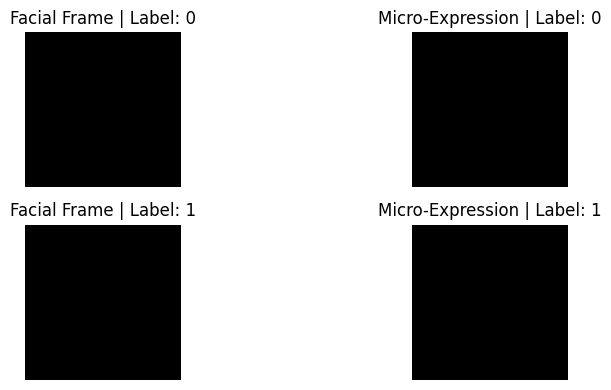

sample_frame_0 type: <class 'numpy.ndarray'>, dtype: uint8
sample_micro_exp_0 type: <class 'numpy.ndarray'>, dtype: uint8
sample_frame_0 shape: (224, 224, 3)
sample_micro_exp_0 shape: (64, 64, 3)
sample_frame_1 type: <class 'numpy.ndarray'>, dtype: uint8
sample_micro_exp_1 type: <class 'numpy.ndarray'>, dtype: uint8
sample_frame_1 shape: (224, 224, 3)
sample_micro_exp_1 shape: (64, 64, 3)


In [10]:
import matplotlib.pyplot as plt

# Initialize flags to track if we've found samples of each class
found_label_0 = False
found_label_1 = False

# Initialize placeholders for samples
sample_frame_0 = None
sample_micro_exp_0 = None
sample_frame_1 = None
sample_micro_exp_1 = None

# Take a batch and unpack it
for batch in train_generator.take(2):
    (X_frames, X_micro_exp), y = batch

    # Print the shapes to verify
    print(f"X_frames shape: {X_frames.shape}")
    print(f"X_micro_exp shape: {X_micro_exp.shape}")
    print(f"y shape: {y.shape}")

    # Loop through the batch to find examples of both labels
    for sample_index in range(len(y)):
        sample_label = int(y[sample_index].numpy()[0])  # Assuming binary classification

        # Check if we already have examples for each label
        if sample_label == 0 and not found_label_0:
            found_label_0 = True
            sample_frame_0 = X_frames[sample_index].numpy()
            sample_micro_exp_0 = X_micro_exp[sample_index].numpy()

        elif sample_label == 1 and not found_label_1:
            found_label_1 = True
            sample_frame_1 = X_frames[sample_index].numpy()
            sample_micro_exp_1 = X_micro_exp[sample_index].numpy()

        # Break loop once we have both examples
        if found_label_0 and found_label_1:
            break

# Ensure the data is not None before processing
if sample_frame_0 is not None and sample_micro_exp_0 is not None:
    sample_frame_0 = sample_frame_0.astype("uint8")
    sample_micro_exp_0 = sample_micro_exp_0.astype("uint8")
else:
    print("Warning: Label 0 data not found in the batch.")

if sample_frame_1 is not None and sample_micro_exp_1 is not None:
    sample_frame_1 = sample_frame_1.astype("uint8")
    sample_micro_exp_1 = sample_micro_exp_1.astype("uint8")
else:
    print("Warning: Label 1 data not found in the batch.")

# Plot
plt.figure(figsize=(10, 4))

if sample_frame_0 is not None and sample_micro_exp_0 is not None:
    # Display facial and micro-expression frames for label 0
    plt.subplot(2, 2, 1)
    plt.imshow(sample_frame_0)
    plt.title("Facial Frame | Label: 0")
    plt.axis("off")

    plt.subplot(2, 2, 2)
    plt.imshow(sample_micro_exp_0)
    plt.title("Micro-Expression | Label: 0")
    plt.axis("off")

if sample_frame_1 is not None and sample_micro_exp_1 is not None:
    # Display facial and micro-expression frames for label 1
    plt.subplot(2, 2, 3)
    plt.imshow(sample_frame_1)
    plt.title("Facial Frame | Label: 1")
    plt.axis("off")

    plt.subplot(2, 2, 4)
    plt.imshow(sample_micro_exp_1)
    plt.title("Micro-Expression | Label: 1")
    plt.axis("off")

plt.tight_layout()
plt.show()

# Print the final details
if sample_frame_0 is not None and sample_micro_exp_0 is not None:
    print(f"sample_frame_0 type: {type(sample_frame_0)}, dtype: {sample_frame_0.dtype}")
    print(f"sample_micro_exp_0 type: {type(sample_micro_exp_0)}, dtype: {sample_micro_exp_0.dtype}")
    print(f"sample_frame_0 shape: {sample_frame_0.shape}")
    print(f"sample_micro_exp_0 shape: {sample_micro_exp_0.shape}")

if sample_frame_1 is not None and sample_micro_exp_1 is not None:
    print(f"sample_frame_1 type: {type(sample_frame_1)}, dtype: {sample_frame_1.dtype}")
    print(f"sample_micro_exp_1 type: {type(sample_micro_exp_1)}, dtype: {sample_micro_exp_1.dtype}")
    print(f"sample_frame_1 shape: {sample_frame_1.shape}")
    print(f"sample_micro_exp_1 shape: {sample_micro_exp_1.shape}")


In [11]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=5e-6
)

In [12]:
optimizer = Adam(learning_rate=1e-4)

In [13]:
model = build_full_model()

In [14]:
model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [15]:
history_df = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=1000,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/1000


560/560 [==============================] - 1326s 2s/step - loss: 0.8935 - accuracy: 0.4936 - val_loss: 0.7799 - val_accuracy: 0.4973 - lr: 1.0000e-04
Epoch 2/1000
560/560 [==============================] - 1275s 2s/step - loss: 0.7907 - accuracy: 0.5044 - val_loss: 0.7765 - val_accuracy: 0.5112 - lr: 1.0000e-04
Epoch 3/1000
560/560 [==============================] - 1276s 2s/step - loss: 0.7844 - accuracy: 0.5019 - val_loss: 0.7769 - val_accuracy: 0.5027 - lr: 1.0000e-04
Epoch 4/1000
560/560 [==============================] - 1277s 2s/step - loss: 0.7797 - accuracy: 0.5092 - val_loss: 0.7739 - val_accuracy: 0.5237 - lr: 1.0000e-04
Epoch 5/1000
560/560 [==============================] - 1275s 2s/step - loss: 0.7787 - accuracy: 0.5165 - val_loss: 0.7678 - val_accuracy: 0.5558 - lr: 1.0000e-04
Epoch 6/1000
560/560 [==============================] - 1274s 2s/step - loss: 0.7724 - accuracy: 0.5287 - val_loss: 0.7687 - val_accuracy: 0.5616 - lr: 1.0000e-04
Epoch 7/1000
560/560

In [16]:

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")

300/300 [==============================] - 193s 642ms/step - loss: 0.6381 - accuracy: 0.6490
Test loss: 0.6381221413612366, Test accuracy: 0.6489583253860474


In [17]:
model.save("lq_model_nt_acc_6489_240225.h5")

c:\Users\USER\anaconda3\envs\Face-Swap-Detection-Model\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
# save the history
with open('history_nt_lq_24022025.pkl', 'wb') as f:
    pickle.dump(history_df.history, f)

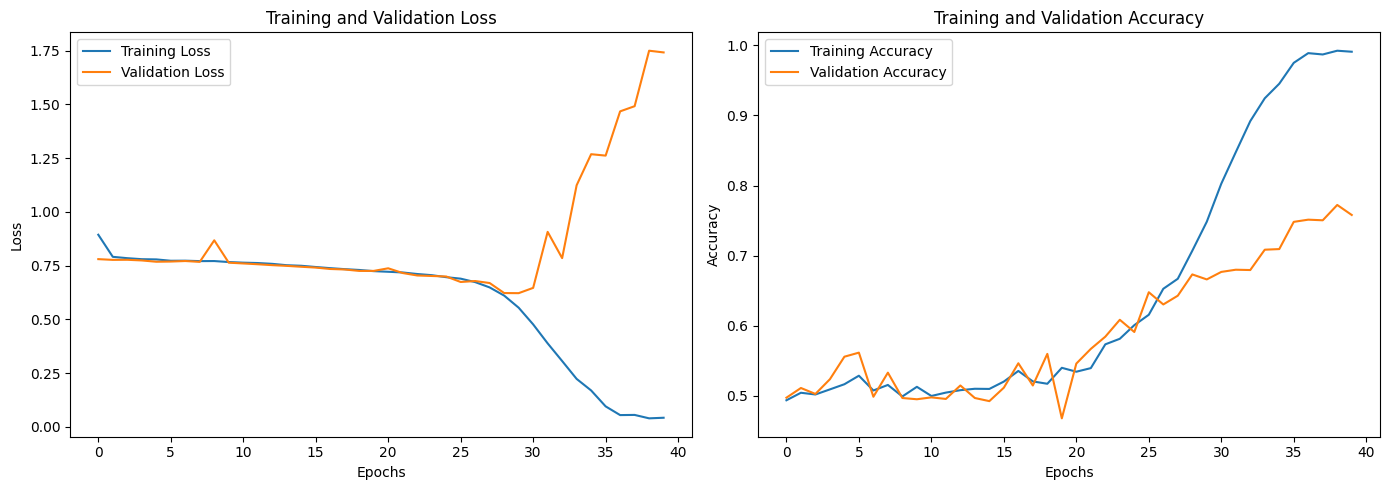

In [19]:
import matplotlib.pyplot as plt

# Plot loss and accuracy for training and validation sets
def plot_history(history):
    # Loss plot
    plt.figure(figsize=(14, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plotting the history of model_2
plot_history(history_df)


In [20]:
# Extract true labels from the test generator
y_true = np.concatenate([y for _, y in test_generator], axis=0)

In [21]:
test_prediction = model.predict(test_generator)

test_prediction_labels = np.argmax(test_prediction, axis=1)

300/300 [==============================] - 214s 651ms/step


In [22]:
# Calculate ROC-AUC Score
from sklearn.metrics import roc_auc_score


roc_auc = roc_auc_score(y_true, test_prediction)
print(f"ROC-AUC Score: {roc_auc:.4f}")

ROC-AUC Score: 0.7132


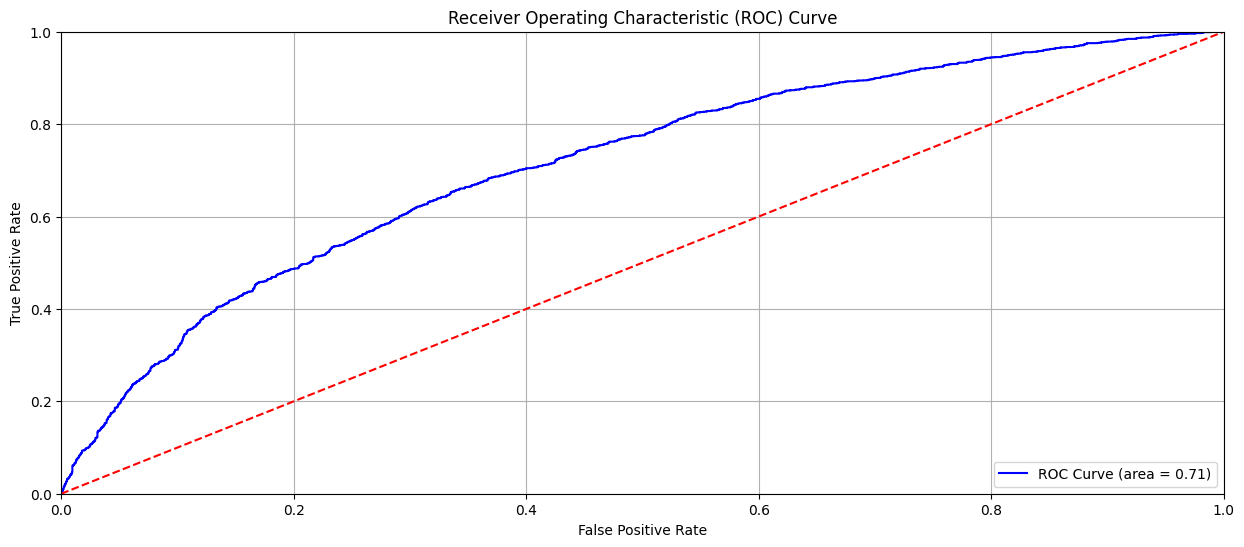

In [23]:
# Calculate ROC curve
from sklearn.metrics import roc_curve


fpr, tpr, thresholds = roc_curve(y_true, test_prediction)

# Plot ROC curve
plt.figure(figsize=(15, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

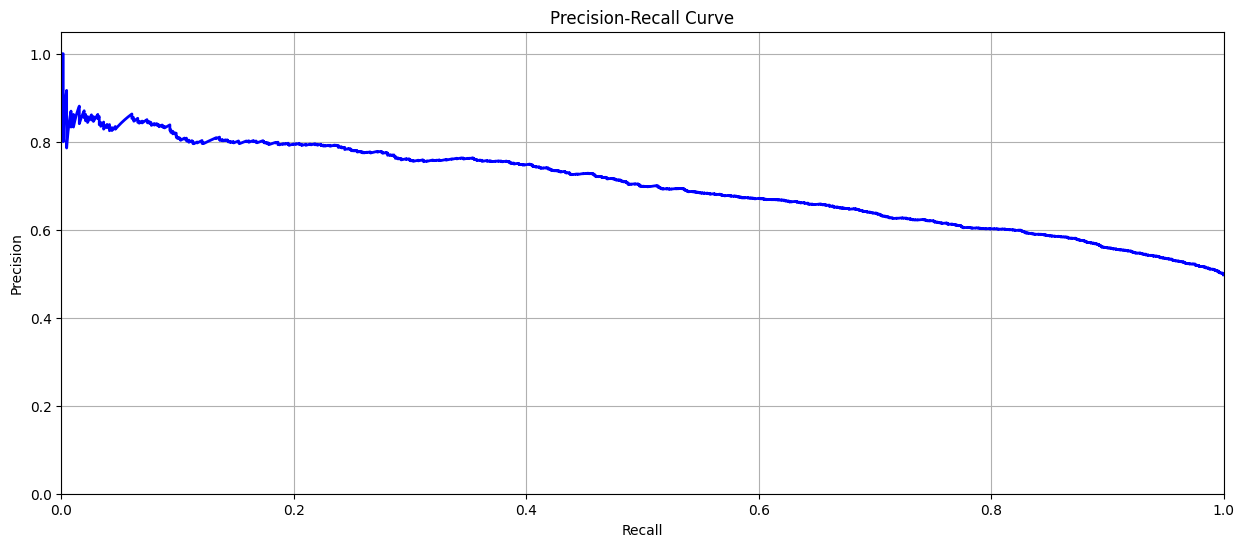

In [24]:
from sklearn.metrics import precision_recall_curve

# Calculate precision and recall
precision, recall, _ = precision_recall_curve(y_true, test_prediction)

# Plotting the Precision-Recall curve
plt.figure(figsize=(15, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid()
plt.show()

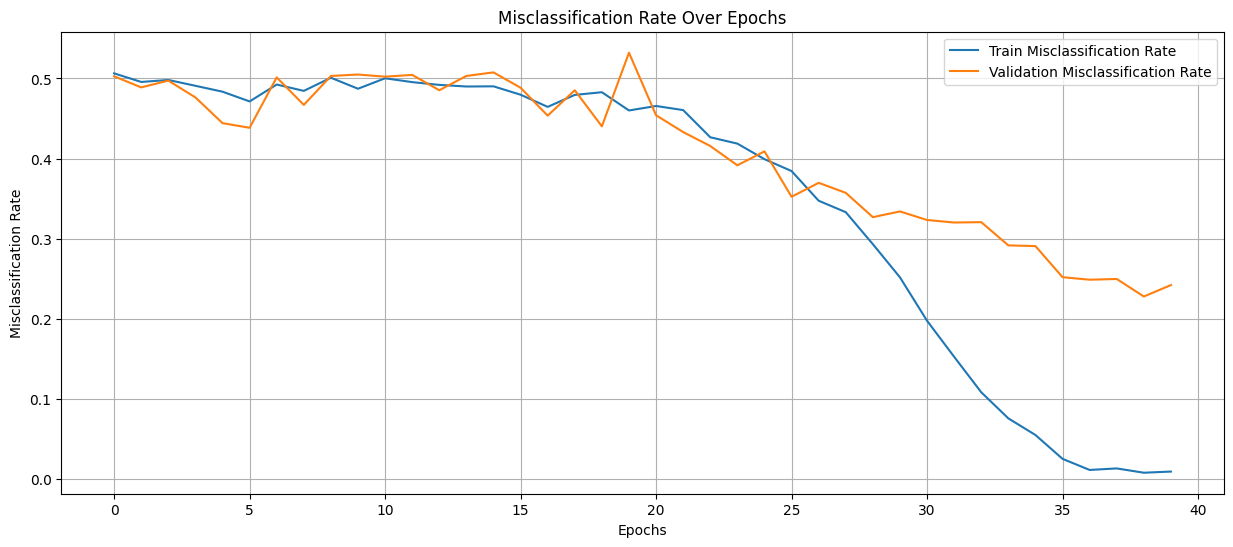

In [25]:
# Misclassification rate for train and validation data
train_misclassification = [1 - acc for acc in history_df.history['accuracy']]
val_misclassification = [1 - val_acc for val_acc in history_df.history['val_accuracy']]

# Plot misclassification rates
plt.figure(figsize=(15, 6))
plt.plot(train_misclassification, label='Train Misclassification Rate')
plt.plot(val_misclassification, label='Validation Misclassification Rate')
plt.xlabel('Epochs')
plt.ylabel('Misclassification Rate')
plt.title('Misclassification Rate Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [26]:
# Assuming test_predictions contains probabilities for the positive class
test_pred_labels = (test_prediction > 0.5).astype(int)

In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Calculate performance metrics
accuracy = accuracy_score(y_true, test_pred_labels)
precision = precision_score(y_true, test_pred_labels, average='weighted')  # Use 'macro' or 'micro' as needed
recall = recall_score(y_true, test_pred_labels, average='weighted')
f1 = f1_score(y_true, test_pred_labels, average='weighted')
confusion_mat = confusion_matrix(y_true, test_pred_labels)

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:\n", confusion_mat)

Accuracy: 0.6490
Precision: 0.6555
Recall: 0.6490
F1 Score: 0.6448
Confusion Matrix:
 [[1824  589]
 [1096 1291]]


In [30]:
report = classification_report(y_true, test_pred_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

         0.0       0.62      0.76      0.68      2413
         1.0       0.69      0.54      0.61      2387

    accuracy                           0.65      4800
   macro avg       0.66      0.65      0.64      4800
weighted avg       0.66      0.65      0.64      4800



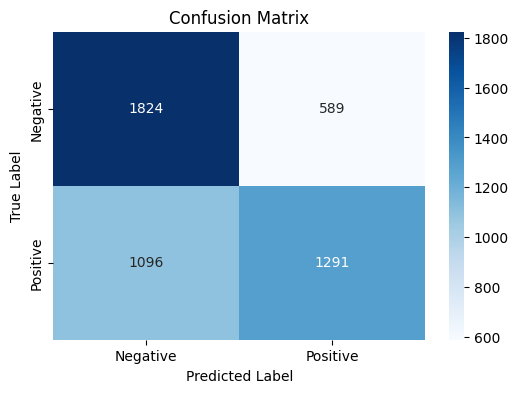

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, test_pred_labels)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
